# Welcome to the PySPI tutorial!

This tutorial will show you how to get started with `pyspi` and to use it for classifying your own multivariate time series (MTS).

## Computing all pairwise interactions for one MTS

The first part of the tutorial illustrates how to use the `Calculator` class to compute all SPIs.

Before we get started, we will need to download the data: the daily open price of five popular stocks (known as the *FAANG* index).

In [1]:
""" First, we need to set up some tools for downloading and minimally processing the data 
"""
import datetime, warnings
import pandas_datareader as pdr
import pandas as pd
import numpy as np
from scipy.stats import zscore
from scipy.signal import detrend

def download(symbols,start,days):
    """ Download financial data from one of two sources, Yahoo Finance (yahoo) and the St. Lois Federal Reserve (fred)
    """
    end = start + datetime.timedelta(days=days)

    startstr = start.strftime('%Y-%m-%d')
    endstr = end.strftime('%Y-%m-%d')

    print(f'Obtaining {symbols} data from {startstr} to {endstr}...')
    try:
        # Attempting to use Yahoo Finance...
        with warnings.catch_warnings(record=True) as w:
            warnings.simplefilter('always')
            close = pdr.DataReader(symbols, 'yahoo', startstr, endstr)['Close']
    except:
        # Yahoo didn''t work. Switching to FRED.
        close = pdr.DataReader(symbols, 'fred', startstr, endstr)

    # Match data up with weekdays
    weekdays = pd.date_range(start=startstr, end=endstr, freq='B')
    close = close.reindex(weekdays)

    # For any NaN's, propogate last valid value forward (and remove first value) 
    z = close.fillna(method='ffill').values.T[:,2:]

    # Make sure to always detrend and normalise your data, otherwise most statistics will give spurious results.
    return detrend(zscore(z,ddof=1,nan_policy='omit',axis=1))

# The FAANG tickers (Facebook/Meta, Amazon, Apple, Netflix, Google)
stocks = ['FB','AMZN','AAPL','NFLX','GOOGL'] 

# We'll download 140 days of data (corresponding to ~100 observations from business days)
ndays = 140 

# Set a recent(ish) starting date for the period
start_datetime = datetime.datetime.strptime('2014-01-01', '%Y-%m-%d') # Earliest date we will sample

print('Begin data download.')
z = download(stocks,start_datetime,ndays)
print(f'Done. Obtained MTS of size {z.shape}')

Begin data download.
Obtaining ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOGL'] data from 2014-01-01 to 2014-05-21...
Done. Obtained MTS of size (5, 99)


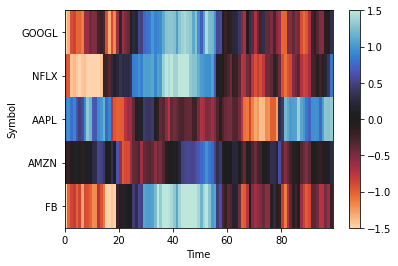

In [2]:
""" Now we've got our data, we can inspect it to make sure everything looks OK.
"""
import matplotlib.pyplot as plt # For plotting
from scipy.stats import zscore
import seaborn as sns

def plot_data(z,labels):
    plt.subplots()
    plt.pcolormesh(z,vmin=-1.5,vmax=1.5,cmap=sns.color_palette('icefire_r',as_cmap=True))
    plt.colorbar()

    ticks = [t+0.5 for t in range(len(labels))]
    plt.yticks(ticks=ticks, labels=labels)
    plt.xlabel('Time')
    plt.ylabel('Symbol')
    plt.show()

plot_data(z,stocks)

In [3]:
""" Now that we have our data, and inspected it to make sure it looks OK, we can compute all pairwise interactions.
"""

from pyspi.calculator import Calculator

# These two lines show the main usage of the calculator: simply instantiate and compute.
calc = Calculator(z)
calc.compute()

# We can now inspect the results table, which includes hundreds of pairwise interactions
print(calc.table)

/home/oliver/miniconda3/envs/pyspi/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/home/oliver/miniconda3/envs/pyspi/lib/python3.9/site-packages/sktime/datatypes/_panel/_check.py:45: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/home/oliver/miniconda3/envs/pyspi/lib/python3.9/site-packages/sktime/datatypes/_panel/_check.py:46: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_MULTIINDEX_TYPES = (pd.Int64Index, pd.RangeIndex)


Loading configuration file: /home/oliver/Dropbox/Workspace/code/research/pyspi/pyspi/config.yaml
*** Importing module .statistics.basic
[0] Adding SPI .statistics.basic.covariance(x,y,{'estimator': 'EmpiricalCovariance'})...
Succesfully initialised SPI with identifier "cov_EmpiricalCovariance" and labels ['basic', 'unordered', 'linear', 'undirected', 'signed']
[1] Adding SPI .statistics.basic.covariance(x,y,{'estimator': 'EllipticEnvelope'})...
Succesfully initialised SPI with identifier "cov_EllipticEnvelope" and labels ['basic', 'unordered', 'linear', 'undirected', 'signed']
[2] Adding SPI .statistics.basic.covariance(x,y,{'estimator': 'GraphicalLasso'})...
Succesfully initialised SPI with identifier "cov_GraphicalLasso" and labels ['basic', 'unordered', 'linear', 'undirected', 'signed']
[3] Adding SPI .statistics.basic.covariance(x,y,{'estimator': 'GraphicalLassoCV'})...
Succesfully initialised SPI with identifier "cov_GraphicalLassoCV" and labels ['basic', 'unordered', 'linear', 'u

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


[83] Adding SPI .statistics.causal.anm(x,y)...
Succesfully initialised SPI with identifier "anm" and labels ['unsigned', 'causal', 'unordered', 'linear', 'directed']
[84] Adding SPI .statistics.causal.cds(x,y)...
Succesfully initialised SPI with identifier "cds" and labels ['unsigned', 'causal', 'unordered', 'nonlinear', 'directed']
[85] Adding SPI .statistics.causal.reci(x,y)...
Succesfully initialised SPI with identifier "reci" and labels ['unsigned', 'causal', 'unordered', 'nonlinear', 'directed']
[86] Adding SPI .statistics.causal.igci(x,y)...
Succesfully initialised SPI with identifier "igci" and labels ['causal', 'directed', 'nonlinear', 'unsigned', 'unordered']
[87] Adding SPI .statistics.causal.ccm(x,y,{'statistic': 'mean'})...
Succesfully initialised SPI with identifier "ccm_E-None_mean" and labels ['causal', 'directed', 'nonlinear', 'temporal', 'signed']
[88] Adding SPI .statistics.causal.ccm(x,y,{'statistic': 'max'})...
Succesfully initialised SPI with identifier "ccm_E-None

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[253] Adding SPI .statistics.wavelet.phase_slope_index(x,y,{'fs': 1})...
Succesfully initialised SPI with identifier "psi_wavelet_mean_fs-1_fmin-0_fmax-0-5_mean" and labels ['unsigned', 'wavelet', 'undirected']
[254] Adding SPI .statistics.wavelet.phase_slope_index(x,y,{'fmin': 0, 'fmax': 0.25})...
Succesfully initialised SPI with identifier "psi_wavelet_mean_fs-1_fmin-0_fmax-0-25_mean" and labels ['unsigned', 'wavelet', 'undirected']
[255] Adding SPI .statistics.wavelet.phase_slope_index(x,y,{'fmin': 0.25, 'fmax': 0.5})...
Succesfully initialised SPI with identifier "psi_wavelet_mean_fs-1_fmin-0-25_fmax-0-5_mean" and labels ['unsigned', 'wavelet', 'undirected']
[256] Adding SPI .statistics.wavelet.phase_slope_index(x,y,{'fmin': 0, 'fmax': 0.5, 'statistic': 'max'})...
Succesfully initialised SPI with identifier "psi_wavelet_max_fs-1_fmin-0_fmax-0-5_max" and labels ['unsigned', 'wavelet', 'undirected']
[257] Adding SPI .statistics.wavelet.phase_slope_index(x,y,{'fmin': 0, 'fmax': 0.25, 

Processing [None: bary_sgddtw_mean]:  25%|██▍       | 70/283 [00:09<00:46,  4.57it/s]              DBA loss is increasing while it should not be. Stopping optimization.
Processing [None: phase_multitaper_mean_fs-1_fmin-0_fmax-0-5]:  49%|████▉     | 139/283 [00:27<01:04,  2.22it/s]Mean of empty slice
Processing [None: phase_multitaper_max_fs-1_fmin-0_fmax-0-5]:  49%|████▉     | 139/283 [00:27<01:04,  2.22it/s]    All-NaN slice encountered
Processing [None: dtf_multitaper_mean_fs-1_fmin-0_fmax-0-5]:  67%|██████▋   | 191/283 [00:28<00:03, 25.74it/s]      WARNING:spectral_connectivity.minimum_phase_decomposition:Maximum iterations reached. 0 of 1 converged
Processing [None: dcoh_multitaper_mean_fs-1_fmin-0_fmax-0-5]:  71%|███████   | 201/283 [00:28<00:03, 21.37it/s]  WARNING:spectral_connectivity.minimum_phase_decomposition:Maximum iterations reached. 0 of 1 converged
Processing [None: pdcoh_multitaper_mean_fs-1_fmin-0_fmax-0-5]:  71%|███████   | 201/283 [00:29<00:03, 21.37it/s]  WARNING:s

spi     cov_EmpiricalCovariance                                          \
process                  proc-0    proc-1    proc-2    proc-3    proc-4   
proc-0                      NaN  0.242115 -0.351633  0.858372  0.924813   
proc-1                 0.242115       NaN -0.068414  0.145988  0.325476   
proc-2                -0.351633 -0.068414       NaN -0.347251 -0.340071   
proc-3                 0.858372  0.145988 -0.347251       NaN  0.834612   
proc-4                 0.924813  0.325476 -0.340071  0.834612       NaN   

spi     cov_EllipticEnvelope                                          ...  \
process               proc-0    proc-1    proc-2    proc-3    proc-4  ...   
proc-0                   NaN  0.340731 -0.485698  1.005709  0.983332  ...   
proc-1              0.340731       NaN -0.265955  0.205653  0.379245  ...   
proc-2             -0.485698 -0.265955       NaN -0.524554 -0.552633  ...   
proc-3              1.005709  0.205653 -0.524554       NaN  1.008824  ...   
proc-4      

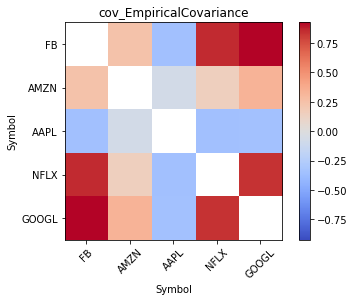

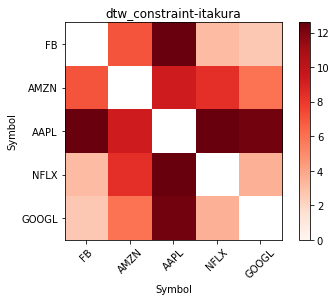

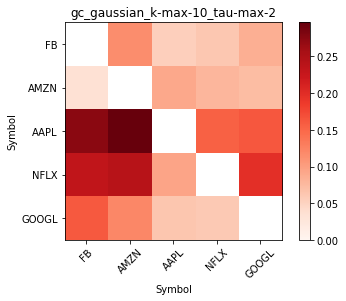

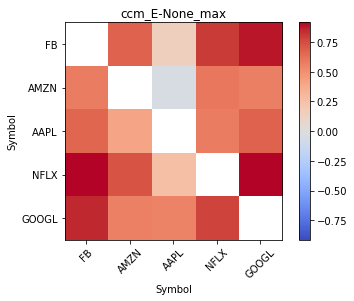

In [4]:
""" One purpose of the calculator is that we can now extract pairwise matrices for every type of interaction.

For instance, below we will examine how covariance, dynamic time warping, and Granger causality differs when computing the relationship between the FAANG stock-market data.
"""

import matplotlib.pyplot as plt
from matplotlib import colors

def plot_mpi(S,identifier,labels,ax=None):
    """ Plot a given matrix of pairwise interactions, annotating the process labels and identifier
    """
    if ax is None:
        _, ax = plt.subplots()
    plt.sca(ax)

    # Use a diverging cmap if our statistic goes negative (and a sequential cmap otherwise)
    if np.nanmin(S) < 0.:
        maxabsval = max(abs(np.nanmin(S)),abs(np.nanmax(S)))
        norm = colors.Normalize(vmin=-maxabsval, vmax=maxabsval)
        plt.imshow(S,cmap='coolwarm',norm=norm)
    else:
        plt.imshow(S,cmap='Reds',vmin=0)

    plt.xticks(ticks=range(len(stocks)),labels=labels,rotation=45)
    plt.yticks(ticks=range(len(stocks)),labels=labels)
    plt.xlabel('Symbol')
    plt.ylabel('Symbol')
    plt.title(identifier)
    plt.colorbar()

# Iterate through the three methods (covariance, dynamic time warping, Granger causality, and convergent cross-mapping), extract and plot their matrices
spis = ['cov_EmpiricalCovariance','dtw_constraint-itakura','gc_gaussian_k-max-10_tau-max-2','ccm_E-None_max']
for identifier in spis:
    # Simply index an SPI in the output table, which will give you an MxM dataframe of pairwise interactions (where M is the number of processes)
    S = calc.table[identifier]

    # Plot this dataframe
    plot_mpi(S,identifier,stocks)

## Classifying MTS

Now that you know how to compute the hundreds of pairwise interactions from data, let's put them to the test!

This part of the tutorial illustrates how to use `sklearn` to classify between two types of time series using a comprehensive representation of their pairwise interactions.

Here, we will try to delineate the stock-market data from earlier from foreign exchange-rate data.

[0/19] Downloading data for the 140 period starting at 2014-05-21 00:00:00.
Obtaining ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOGL'] data from 2014-05-21 to 2014-10-08...


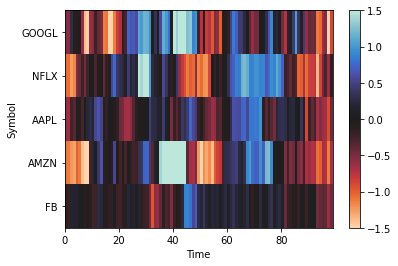

Obtaining ['DEXJPUS', 'DEXUSEU', 'DEXCHUS', 'DEXUSUK', 'DEXCAUS'] data from 2014-05-21 to 2014-10-08...


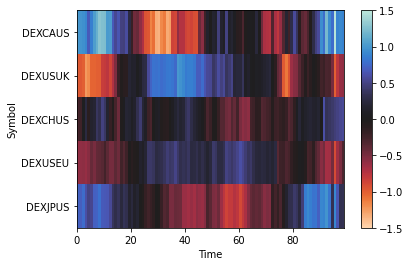

[1/19] Downloading data for the 140 period starting at 2014-10-08 00:00:00.
Obtaining ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOGL'] data from 2014-10-08 to 2015-02-25...


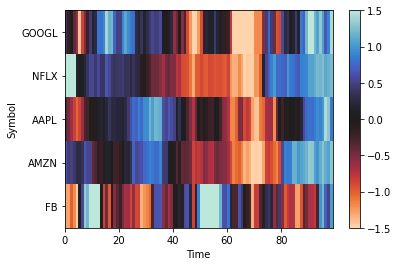

Obtaining ['DEXJPUS', 'DEXUSEU', 'DEXCHUS', 'DEXUSUK', 'DEXCAUS'] data from 2014-10-08 to 2015-02-25...


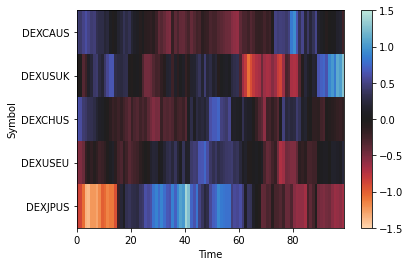

[2/19] Downloading data for the 140 period starting at 2015-02-25 00:00:00.
Obtaining ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOGL'] data from 2015-02-25 to 2015-07-15...


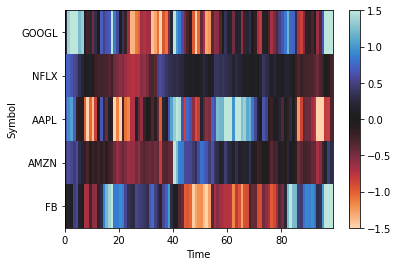

Obtaining ['DEXJPUS', 'DEXUSEU', 'DEXCHUS', 'DEXUSUK', 'DEXCAUS'] data from 2015-02-25 to 2015-07-15...


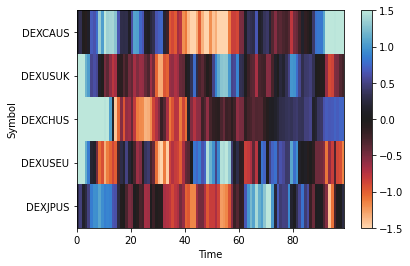

[3/19] Downloading data for the 140 period starting at 2015-07-15 00:00:00.
Obtaining ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOGL'] data from 2015-07-15 to 2015-12-02...


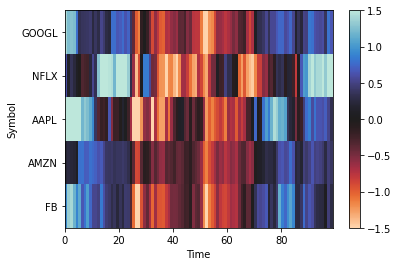

Obtaining ['DEXJPUS', 'DEXUSEU', 'DEXCHUS', 'DEXUSUK', 'DEXCAUS'] data from 2015-07-15 to 2015-12-02...


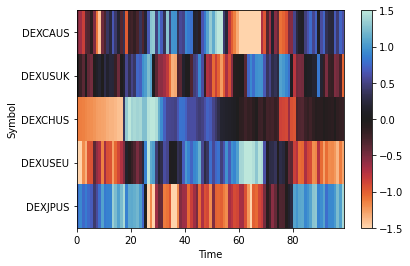

[4/19] Downloading data for the 140 period starting at 2015-12-02 00:00:00.
Obtaining ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOGL'] data from 2015-12-02 to 2016-04-20...


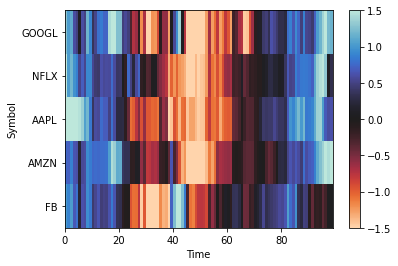

Obtaining ['DEXJPUS', 'DEXUSEU', 'DEXCHUS', 'DEXUSUK', 'DEXCAUS'] data from 2015-12-02 to 2016-04-20...


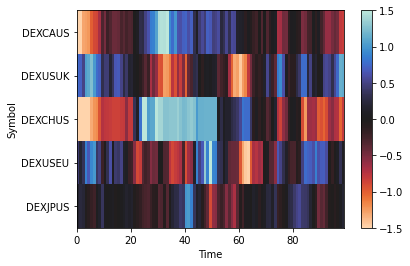

[5/19] Downloading data for the 140 period starting at 2016-04-20 00:00:00.
Obtaining ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOGL'] data from 2016-04-20 to 2016-09-07...


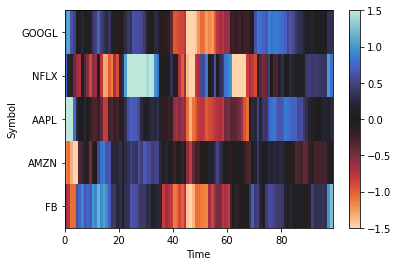

Obtaining ['DEXJPUS', 'DEXUSEU', 'DEXCHUS', 'DEXUSUK', 'DEXCAUS'] data from 2016-04-20 to 2016-09-07...


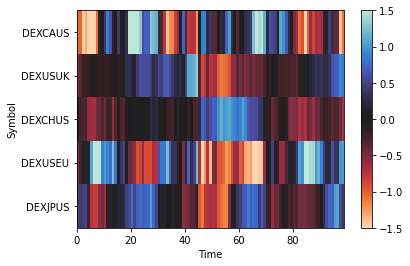

[6/19] Downloading data for the 140 period starting at 2016-09-07 00:00:00.
Obtaining ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOGL'] data from 2016-09-07 to 2017-01-25...


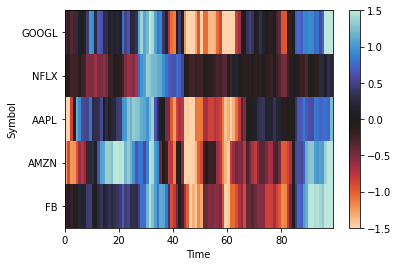

Obtaining ['DEXJPUS', 'DEXUSEU', 'DEXCHUS', 'DEXUSUK', 'DEXCAUS'] data from 2016-09-07 to 2017-01-25...


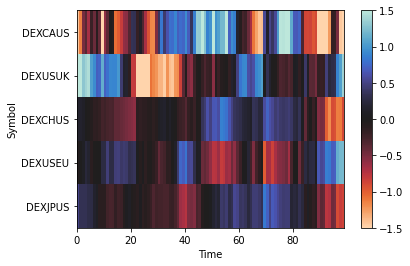

[7/19] Downloading data for the 140 period starting at 2017-01-25 00:00:00.
Obtaining ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOGL'] data from 2017-01-25 to 2017-06-14...


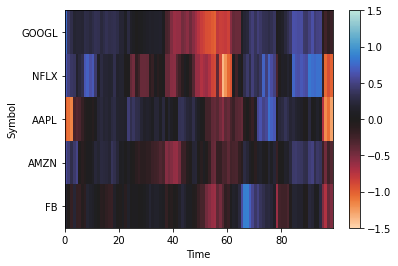

Obtaining ['DEXJPUS', 'DEXUSEU', 'DEXCHUS', 'DEXUSUK', 'DEXCAUS'] data from 2017-01-25 to 2017-06-14...


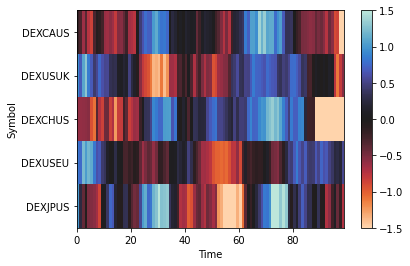

[8/19] Downloading data for the 140 period starting at 2017-06-14 00:00:00.
Obtaining ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOGL'] data from 2017-06-14 to 2017-11-01...


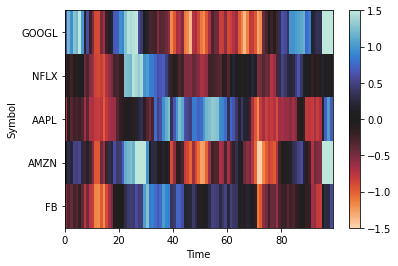

Obtaining ['DEXJPUS', 'DEXUSEU', 'DEXCHUS', 'DEXUSUK', 'DEXCAUS'] data from 2017-06-14 to 2017-11-01...


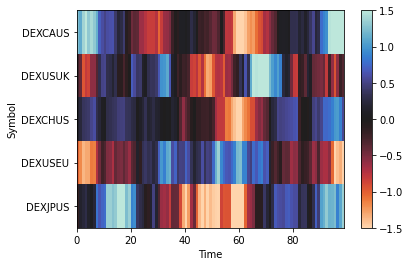

[9/19] Downloading data for the 140 period starting at 2017-11-01 00:00:00.
Obtaining ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOGL'] data from 2017-11-01 to 2018-03-21...


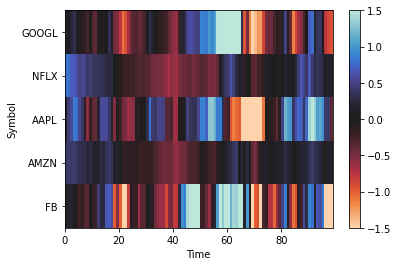

Obtaining ['DEXJPUS', 'DEXUSEU', 'DEXCHUS', 'DEXUSUK', 'DEXCAUS'] data from 2017-11-01 to 2018-03-21...


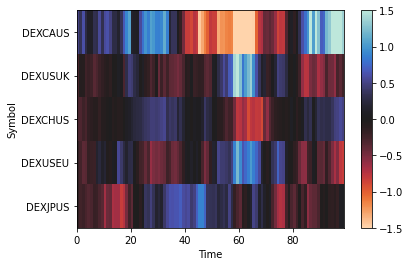

[10/19] Downloading data for the 140 period starting at 2018-03-21 00:00:00.
Obtaining ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOGL'] data from 2018-03-21 to 2018-08-08...


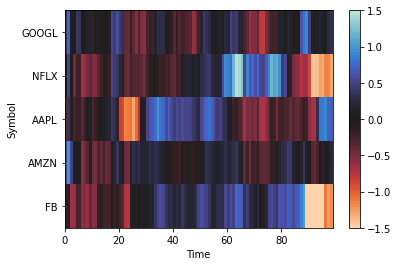

Obtaining ['DEXJPUS', 'DEXUSEU', 'DEXCHUS', 'DEXUSUK', 'DEXCAUS'] data from 2018-03-21 to 2018-08-08...


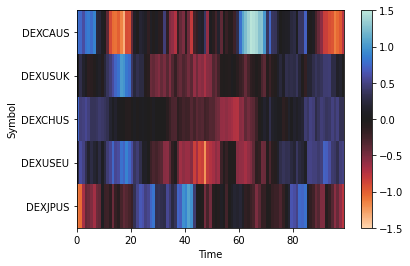

[11/19] Downloading data for the 140 period starting at 2018-08-08 00:00:00.
Obtaining ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOGL'] data from 2018-08-08 to 2018-12-26...


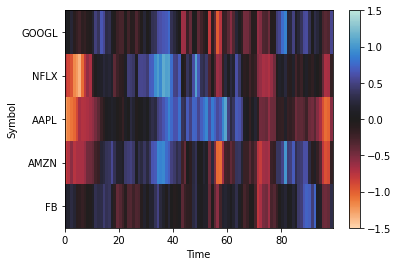

Obtaining ['DEXJPUS', 'DEXUSEU', 'DEXCHUS', 'DEXUSUK', 'DEXCAUS'] data from 2018-08-08 to 2018-12-26...


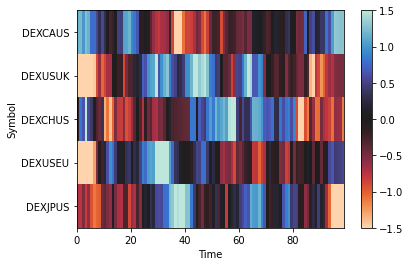

[12/19] Downloading data for the 140 period starting at 2018-12-26 00:00:00.
Obtaining ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOGL'] data from 2018-12-26 to 2019-05-15...


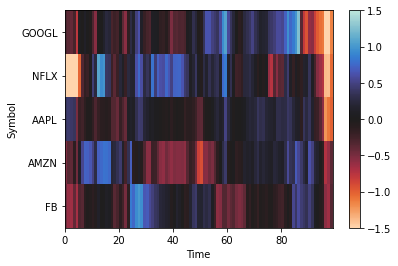

Obtaining ['DEXJPUS', 'DEXUSEU', 'DEXCHUS', 'DEXUSUK', 'DEXCAUS'] data from 2018-12-26 to 2019-05-15...


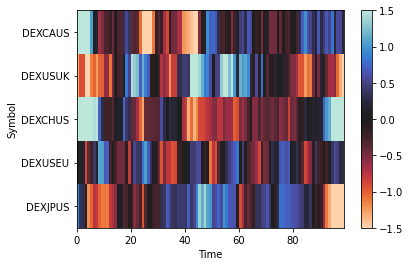

[13/19] Downloading data for the 140 period starting at 2019-05-15 00:00:00.
Obtaining ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOGL'] data from 2019-05-15 to 2019-10-02...


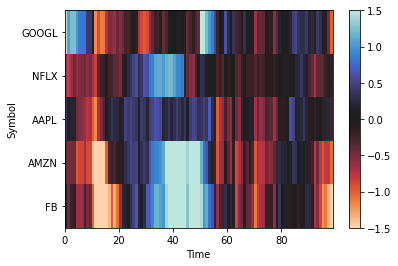

Obtaining ['DEXJPUS', 'DEXUSEU', 'DEXCHUS', 'DEXUSUK', 'DEXCAUS'] data from 2019-05-15 to 2019-10-02...


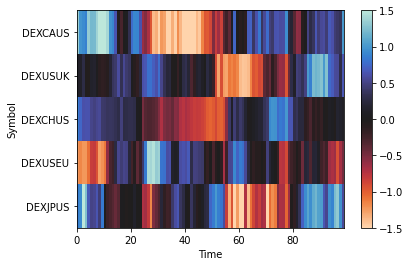

[14/19] Downloading data for the 140 period starting at 2019-10-02 00:00:00.
Obtaining ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOGL'] data from 2019-10-02 to 2020-02-19...


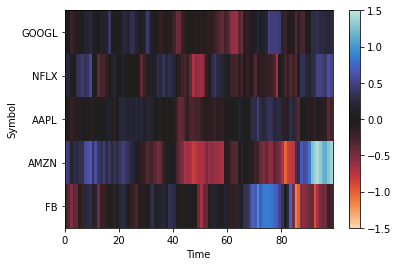

Obtaining ['DEXJPUS', 'DEXUSEU', 'DEXCHUS', 'DEXUSUK', 'DEXCAUS'] data from 2019-10-02 to 2020-02-19...


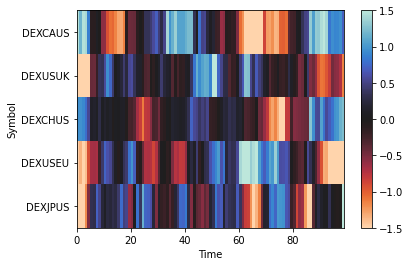

[15/19] Downloading data for the 140 period starting at 2020-02-19 00:00:00.
Obtaining ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOGL'] data from 2020-02-19 to 2020-07-08...


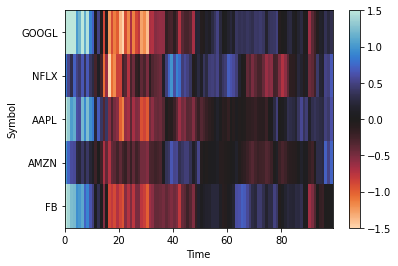

Obtaining ['DEXJPUS', 'DEXUSEU', 'DEXCHUS', 'DEXUSUK', 'DEXCAUS'] data from 2020-02-19 to 2020-07-08...


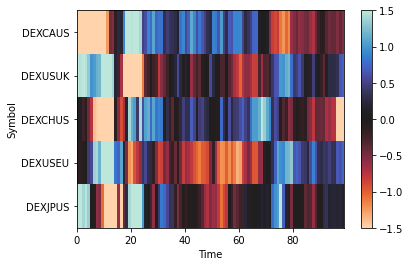

[16/19] Downloading data for the 140 period starting at 2020-07-08 00:00:00.
Obtaining ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOGL'] data from 2020-07-08 to 2020-11-25...


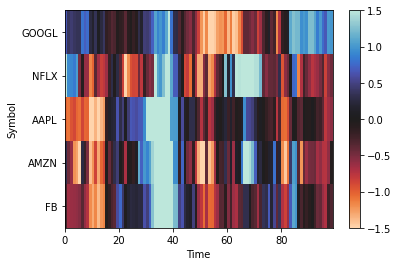

Obtaining ['DEXJPUS', 'DEXUSEU', 'DEXCHUS', 'DEXUSUK', 'DEXCAUS'] data from 2020-07-08 to 2020-11-25...


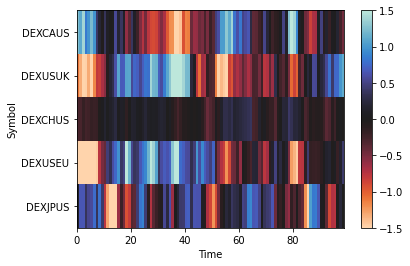

[17/19] Downloading data for the 140 period starting at 2020-11-25 00:00:00.
Obtaining ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOGL'] data from 2020-11-25 to 2021-04-14...


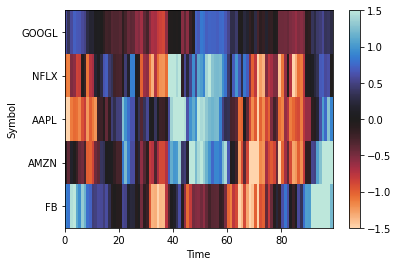

Obtaining ['DEXJPUS', 'DEXUSEU', 'DEXCHUS', 'DEXUSUK', 'DEXCAUS'] data from 2020-11-25 to 2021-04-14...


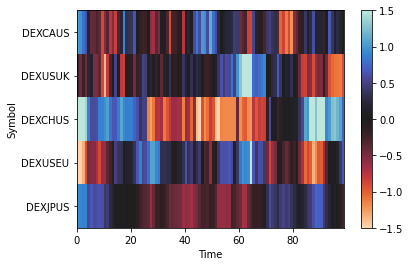

[18/19] Downloading data for the 140 period starting at 2021-04-14 00:00:00.
Obtaining ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOGL'] data from 2021-04-14 to 2021-09-01...


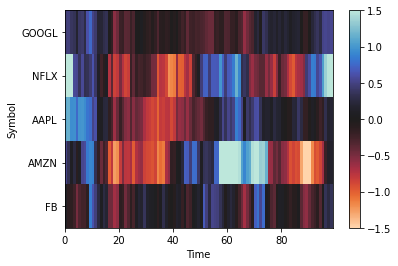

Obtaining ['DEXJPUS', 'DEXUSEU', 'DEXCHUS', 'DEXUSUK', 'DEXCAUS'] data from 2021-04-14 to 2021-09-01...


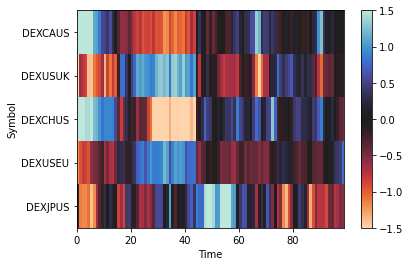

[19/19] Downloading data for the 140 period starting at 2021-09-01 00:00:00.
Obtaining ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOGL'] data from 2021-09-01 to 2022-01-19...


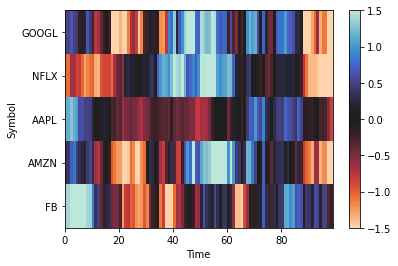

Obtaining ['DEXJPUS', 'DEXUSEU', 'DEXCHUS', 'DEXUSUK', 'DEXCAUS'] data from 2021-09-01 to 2022-01-19...


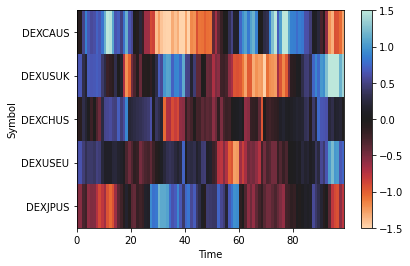

Successfully downloaded 20 datasets of both types of data.


In [5]:
""" First, we need to download several instances of the data type for training/testing our classifier.

This may take a while..
"""

# Add in some more symbols for the market rates
forex = ['DEXJPUS','DEXUSEU','DEXCHUS','DEXUSUK','DEXCAUS']

ninstances = 20

# Dict to store our results (given by the key (type,starting date))
database = {}
for i in range(ninstances):
    # Iterate the start datetime by ndays for each instance
    start_datetime = start_datetime + datetime.timedelta(days=ndays)
    print(f'[{i}/{ninstances-1}] Downloading data for the 140 period starting at {start_datetime}.')

    # Download the stock data (and plot)
    database[('stocks',start_datetime)] = download(stocks,start_datetime,ndays)
    plot_data(database[('stocks',start_datetime)],stocks)
    
    # Download the forex data (and plot)
    database[('forex',start_datetime)] = download(forex,start_datetime,ndays)
    plot_data(database[('forex',start_datetime)],forex)

print(f'Successfully downloaded {ninstances} datasets of both types of data.')

In [6]:
""" Now, compute all pairwise interactions from all datasets (storing the results)
"""
from copy import deepcopy

# First, let's create one calculator and copy it for each MTS so that we don't need to re-initialise each time
calc = Calculator()

results = {}
for key in database:

    # Copy the top-level calculator
    mycalc = deepcopy(calc)

    # Name the calculator after the type of data (stock/forex) plus the starting date
    mycalc.name = key[0] + '_' + key[1].strftime('%Y-%m-%d')
    
    # Ensure we have no NaNs in our dataset (preferably using a more clever way of data imputation than this one)
    dataset = np.nan_to_num(database[key])

    # Load the dataset
    mycalc.load_dataset(dataset)

    # Compute all pairwise interactions
    mycalc.compute()

    # Store our results
    results[key] = mycalc.table

Loading configuration file: /home/oliver/Dropbox/Workspace/code/research/pyspi/pyspi/config.yaml
*** Importing module .statistics.basic
[0] Adding SPI .statistics.basic.covariance(x,y,{'estimator': 'EmpiricalCovariance'})...
Succesfully initialised SPI with identifier "cov_EmpiricalCovariance" and labels ['basic', 'unordered', 'linear', 'undirected', 'signed']
[1] Adding SPI .statistics.basic.covariance(x,y,{'estimator': 'EllipticEnvelope'})...
Succesfully initialised SPI with identifier "cov_EllipticEnvelope" and labels ['basic', 'unordered', 'linear', 'undirected', 'signed']
[2] Adding SPI .statistics.basic.covariance(x,y,{'estimator': 'GraphicalLasso'})...
Succesfully initialised SPI with identifier "cov_GraphicalLasso" and labels ['basic', 'unordered', 'linear', 'undirected', 'signed']
[3] Adding SPI .statistics.basic.covariance(x,y,{'estimator': 'GraphicalLassoCV'})...
Succesfully initialised SPI with identifier "cov_GraphicalLassoCV" and labels ['basic', 'unordered', 'linear', 'u

Processing [stocks_2014-05-21: bary_sgddtw_mean]:  22%|██▏       | 61/283 [00:02<00:11, 19.71it/s]              DBA loss is increasing while it should not be. Stopping optimization.
Processing [stocks_2014-05-21: phase_multitaper_mean_fs-1_fmin-0_fmax-0-5]:  49%|████▉     | 138/283 [00:11<00:18,  8.03it/s]Mean of empty slice
Processing [stocks_2014-05-21: phase_multitaper_max_fs-1_fmin-0_fmax-0-5]:  49%|████▉     | 140/283 [00:11<00:19,  7.18it/s]    All-NaN slice encountered
Processing [forex_2014-05-21: bary_sgddtw_mean]:  17%|█▋        | 49/283 [00:02<00:01, 184.23it/s]              DBA loss is increasing while it should not be. Stopping optimization.
Processing [forex_2014-05-21: phase_multitaper_mean_fs-1_fmin-0_fmax-0-5]:  49%|████▉     | 138/283 [00:13<00:21,  6.77it/s]Mean of empty slice
Processing [forex_2014-05-21: phase_multitaper_max_fs-1_fmin-0_fmax-0-5]:  49%|████▉     | 140/283 [00:13<00:24,  5.86it/s]    All-NaN slice encountered
Processing [forex_2014-05-21: dtf_multit

In [7]:
""" Can we tell if it's ForEx data or stock-market data based on a covariance matrix?
"""
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

def get_data_matrix(table,spi):
    """ For a given SPI, extract the off-diagonals as feature vectors
    """

    # For each dataset in the results table...
    for k in table:
        # ...Extract the matrix corresponding to this SPI...
        A = table[k][spi].values

        # ...Vectorise and join the upper and lower triangles to form a feature vector...
        x = np.concatenate([A[np.triu_indices(A.shape[0],1)],
                            A[np.tril_indices(A.shape[0],-1)]])
        x = np.atleast_2d(x)

        # ...and concatenate each feature vector together to form a data matrix
        try:
            X = np.concatenate([X,x], axis=0)
        except NameError:
            X = x
    return X

def get_accuracy(clf,X,y):
    nrepeats = 5
    score = np.full(nrepeats,np.nan)
    for r in range(nrepeats):
        # Convert the data into half-half train/test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=r)

        # Normalise the features so that the SVM behaves well
        X_train = scaler.fit_transform(X_train)

        # Fit the classifier
        clf.fit(X_train,y_train)

        # Scale the test data (with the same scaler as above)
        X_test = scaler.transform(X_test)

        # Predict the output
        y_pred = clf.predict(X_test)

        # Get the accuracy for this train/test split (should be balanced)
        score[r] = balanced_accuracy_score(y_test, y_pred)
    
    # Return the average score
    return np.nanmean(score)

# First check with the standard covariance matrix
spi = 'cov_EmpiricalCovariance'
X = get_data_matrix(results,spi)

# Set up the dataset labels for classification ("forex" == 0, "stocks" == 1)
y = np.array([int(key[0] == 'stocks') for key in results])

# Linear SVM classifier using the default settings
clf = svm.SVC(kernel='linear')

score = get_accuracy(clf,X,y)

print(f'Average accuracy for {spi} in delineating ForEx from FAANG data: {score}')


Average accuracy for cov_EmpiricalCovariance in delineating ForEx from FAANG data: 0.9809090909090908


In [8]:
""" Let's try this out for every SPI and see how they all perform
"""
from sklearn.model_selection import train_test_split

# Repeat last cell for each SPI
scores = {}
spis = mycalc.spis.keys()
for spi in spis:
    X = get_data_matrix(results,spi)
    try:
        scores[spi] = get_accuracy(clf, X, y)
        print(f'Average score for {spi}: {scores[spi]}')
    except ValueError as err:
        print(f'Issue with SPI {spi}: {err}')

Average score for cov_EmpiricalCovariance: 0.9809090909090908
Average score for cov_EllipticEnvelope: 0.9278535353535353
Average score for cov_GraphicalLasso: 0.9809090909090908
Average score for cov_GraphicalLassoCV: 0.9618181818181817
Average score for cov_LedoitWolf: 0.9718181818181819
Average score for cov_MinCovDet: 0.9403535353535354
Average score for cov_OAS: 0.9718181818181819
Average score for cov_ShrunkCovariance: 0.9809090909090908
Average score for cov-sq_EmpiricalCovariance: 0.5117171717171717
Average score for cov-sq_EllipticEnvelope: 0.6283585858585858
Average score for cov-sq_GraphicalLasso: 0.5024747474747475
Average score for cov-sq_GraphicalLassoCV: 0.4819191919191919
Average score for cov-sq_LedoitWolf: 0.5196969696969697
Average score for cov-sq_MinCovDet: 0.6274494949494949
Average score for cov-sq_OAS: 0.5244949494949495
Average score for cov-sq_ShrunkCovariance: 0.5117171717171717
Average score for prec_EmpiricalCovariance: 0.8312121212121213
Average score for p

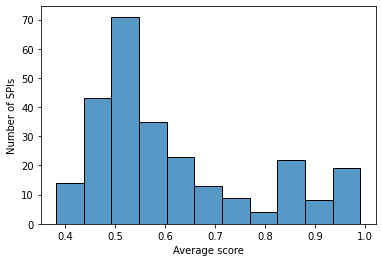

bary_euclidean_mean                                       0.382096
wpli_multitaper_max_fs-1_fmin-0_fmax-0-5                  0.387828
pli_multitaper_max_fs-1_fmin-0-25_fmax-0-5                0.389242
icoh_multitaper_max_fs-1_fmin-0_fmax-0-5                  0.394773
pec_orth_log_abs                                          0.395530
pli_multitaper_max_fs-1_fmin-0_fmax-0-5                   0.410051
te_kernel_W-0.25_k-1                                      0.412071
ccm_E-None_max                                            0.413586
igci                                                      0.424520
wpli_multitaper_max_fs-1_fmin-0_fmax-0-25                 0.425682
lmfit_Lasso                                               0.430126
coint_johansen_trace_stat_order-1_ardiff-10               0.430606
coint_johansen_trace_stat_order-0_ardiff-10               0.430606
xcorr-sq_mean_sig-True                                    0.431086
ccm_E-10_max                                              0.43

In [9]:
""" And plot the results
"""

import seaborn as sns

# Get a histogram 
sns.histplot(scores)
plt.xlabel('Average score')
plt.ylabel('Number of SPIs')
plt.show()

# Load into a pandas series to pretty-print the results
ser = pd.Series(scores)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(ser.dropna().sort_values())

plt.show()

Inspecting top SPI (phase_multitaper_max_fs-1_fmin-0-25_fmax-0-5) in more detail...


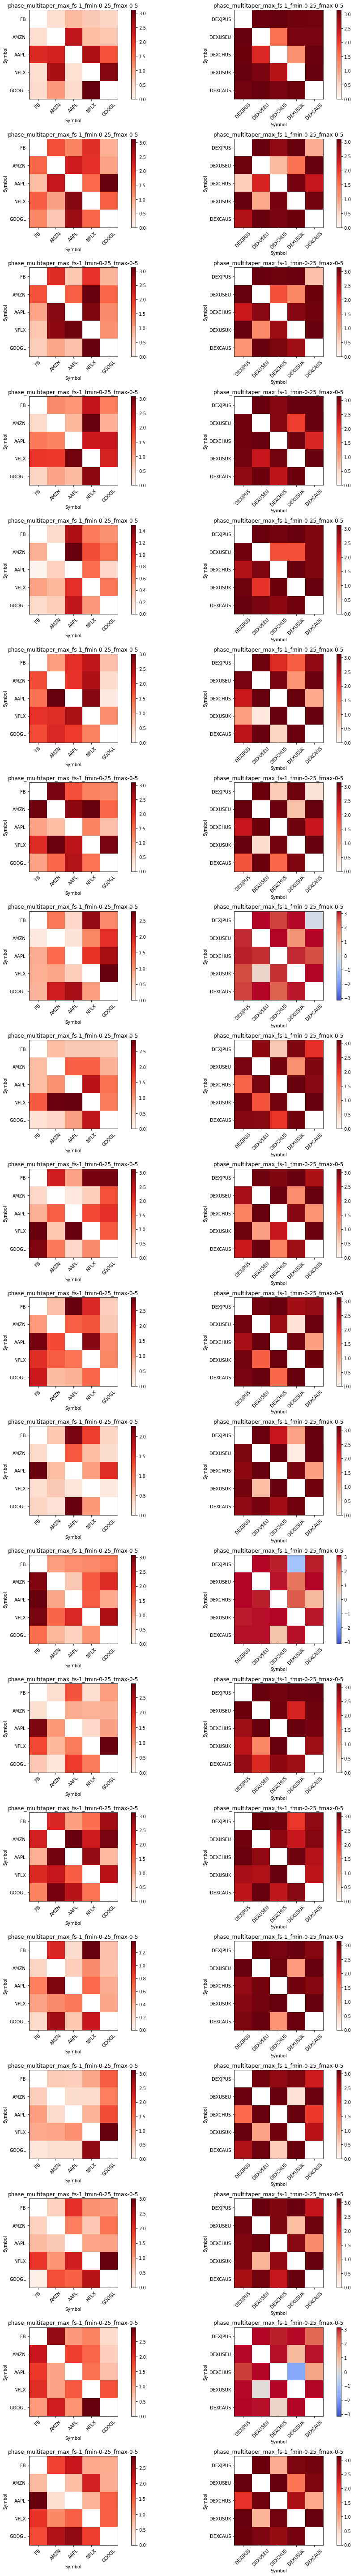

In [10]:
""" We can inspect the MPIs to see what was the distinguishing feature for our top performing SPI
"""

# Get our top-performing SPI
topspi = ser.index[ser.argmax()]
print(f'Inspecting top SPI ({topspi}) in more detail...')

# Unique time periods and datatypes
periods = np.unique([k[1] for k in results])
dtypes = ['stocks','forex']

# Set up our axes
fig, axs = plt.subplots(len(periods),2,figsize=(15,80))
for (d, p) in results:
    
    # Get the MPI for this dataset
    S = results[(d,p)][topspi]

    # The axis position
    i = [_i for _i, _p in enumerate(periods) if _p == p][0]
    j = [_j for _j, _d in enumerate(dtypes) if _d == d][0]

    # stocks or forex labels
    labels = globals()[dtypes[j]]

    # Plot the MPI
    plot_mpi(S,topspi,labels,ax=axs[i,j])
    plt.subplots_adjust(hspace=1.)

plt.tight_layout()
plt.show()